# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%env CUDA_VISIBLE_DEVICES=0
%env BLISS_HOME=/home/yppatel/bliss

Modules to reload:
all-except-skipped

Modules to skip:

env: CUDA_VISIBLE_DEVICES=0
env: BLISS_HOME=/home/yppatel/bliss


In [23]:
%matplotlib inline 

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.substructure.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

In [4]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

0


# Encoder blend images

In [9]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="config"):
    cfg = compose("config", overrides=[])
    
    
enc, dec = load_models(cfg, device)
bp = enc.border_padding
torch.cuda.empty_cache()

tile_slen = 4
ptile_slen = 100
slen = 92


In [26]:
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

InstantiationException: Error in call to target 'bliss.datasets.simulated.SimulatedDataset':
RuntimeError('context has already been set')
full_key: datasets.simulated

In [27]:
sample_batch_size = 16
tile_catalog = dataset.sample_prior(sample_batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
tile_catalog.set_all_fluxes_and_mags(dataset.image_decoder)

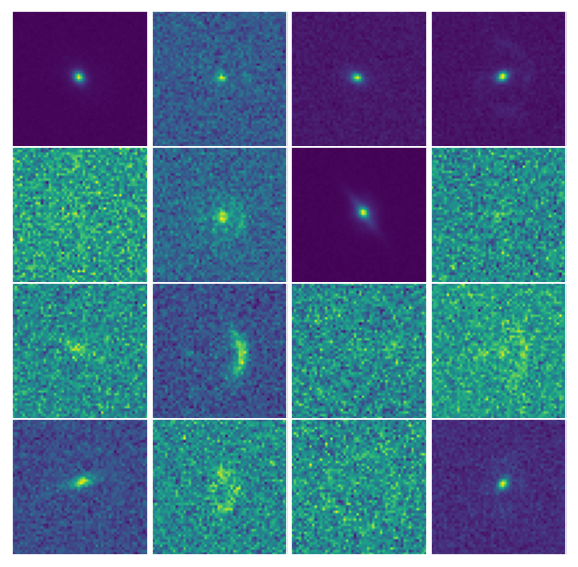

In [28]:
images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)
plt.rcParams["axes.grid"] = False

fig, axs = plt.subplots(sample_batch_size // 4, 4, figsize=(6, 6), dpi=120)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(sample_batch_size):
    axs[i // 4, i % 4].imshow(images[i,0,:,:].cpu())
    axs[i // 4, i % 4].set_xticklabels([])
    axs[i // 4, i % 4].set_yticklabels([])
    axs[i // 4, i % 4].tick_params(left = False, bottom = False)